In [1]:
# 1. Imports
import os
import gc
from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from scipy import interpolate

from transformers import Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from safetensors.torch import load_file
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from transformers import AutoModel



In [2]:
# 2. ----------------------- CONFIG -----------------------
BATCH_SIZE = 8
NUM_EPOCHS = 50  # Trying 5 epochs for debugging, increase later
PATIENCE = 0
MODEL_PATH = "C:\\K2452367\\Dissertation\\blip2_model\\models--Salesforce--blip2-opt-2.7b\\snapshots\\59a1ef6c1e5117b3f65523d1c6066825bcf315e3"
TRAIN_CSV = "C:\\K2452367\\Dissertation\\Deepfakedetection_masters_2025\\FF++(HQ)\\FF++(HQ)_CSV\\combined_training_original_cross_data_full_with_augmentation.csv"
VAL_CSV = "C:\\K2452367\\Dissertation\\Deepfakedetection_masters_2025\\FF++(HQ)\\FF++(HQ)_CSV\\combined_validation_original_cross_data_full_with_augmentation.csv"
TEST_CSV = "C:\\K2452367\\Dissertation\\Deepfakedetection_masters_2025\\FF++(HQ)\\FF++(HQ)_CSV\\combined_testing_original_cross_data_full_with_augmentation.csv"
SAVE_PATH_BASE = "C:\\K2452367\\Dissertation\\lora_blip2"  # LoRa layers
SAVE_PATH_HEAD = "C:\\K2452367\\Dissertation\\classifier_head.pth"  # BLIP head
CHECKPOINT_PATH = "checkpoint_refined.pt"  # use SAME path everywhere

BEST_LR = 1e-4
BEST_DROPOUT = 0.1
BEST_WD = 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True
)

In [3]:
# 3. -----------------------------GPU Utilization----------------------
if torch.cuda.is_available():
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Allocated memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Cached memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("CUDA not available\n")

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Total GPU memory: 24.00 GB
Allocated memory: 0.00 GB
Cached memory: 0.00 GB
CUDA Available: True
CUDA Version: 11.8
Number of GPUs: 1
Current CUDA device: 0
Device Name: NVIDIA GeForce RTX 3090


In [4]:
# 4. ---------------------- DATASET -----------------------
class DeepfakeBLIPDataset(Dataset):
    def __init__(self, df, real_text="This is a real image", fake_text="This is a fake image"):
        self.df = df.reset_index(drop=True)
        self.real = real_text
        self.fake = fake_text

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["path"]).convert("RGB")  # PIL
        lbl = int(row["label"])
        txt = self.real if lbl == 0 else self.fake
        return img, txt, lbl

def blip_collate(batch):
    imgs, txts, lbls = zip(*batch)
    return list(imgs), list(txts), torch.tensor(lbls, dtype=torch.long)

In [5]:
# 5. ---------------------- LOAD DATA (balanced 5k per split) ---------------------
def balanced_subsample(df, n_total=5000, label_col="label", seed=42):
    """
    Return a balanced subset with n_total rows, split equally across classes.
    Assumes binary labels (0/1). Raises if a class doesn't have enough samples.
    """
    classes = sorted(df[label_col].unique())
    if len(classes) != 2:
        raise ValueError(f"Expected 2 classes, got {len(classes)}: {classes}")

    n_per_class = n_total // 2
    subsets = []
    for c in classes:
        df_c = df[df[label_col] == c]
        if len(df_c) < n_per_class:
            raise ValueError(
                f"Not enough samples for class {c}: need {n_per_class}, have {len(df_c)}"
            )
        subsets.append(df_c.sample(n=n_per_class, replace=False, random_state=seed))

    out = pd.concat(subsets, axis=0)
    # Shuffle the combined subset
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

# Read full CSVs
train_df_full = pd.read_csv(TRAIN_CSV)
val_df_full   = pd.read_csv(VAL_CSV)
test_df_full  = pd.read_csv(TEST_CSV)

# Make balanced 5k subsets
SPLIT_SIZE = 5000
train_df = balanced_subsample(train_df_full, n_total=SPLIT_SIZE, label_col="label", seed=42)
val_df   = balanced_subsample(val_df_full,   n_total=SPLIT_SIZE, label_col="label", seed=42)
test_df  = balanced_subsample(test_df_full,  n_total=SPLIT_SIZE, label_col="label", seed=42)

# Show distributions to verify balance
print("\nBalanced label distribution (train):\n", train_df["label"].value_counts().sort_index())
print("\nBalanced label distribution (val):\n",   val_df["label"].value_counts().sort_index())
print("\nBalanced label distribution (test):\n",  test_df["label"].value_counts().sort_index())

# Build loaders (you can tune num_workers/pin_memory as you like)
train_loader = DataLoader(
    DeepfakeBLIPDataset(train_df),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=blip_collate,
    pin_memory=True
)
val_loader = DataLoader(
    DeepfakeBLIPDataset(val_df),
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    collate_fn=blip_collate,
    pin_memory=True
)
test_loader = DataLoader(
    DeepfakeBLIPDataset(test_df),
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    collate_fn=blip_collate,
    pin_memory=True
)



Balanced label distribution (train):
 label
0    2500
1    2500
Name: count, dtype: int64

Balanced label distribution (val):
 label
0    2500
1    2500
Name: count, dtype: int64

Balanced label distribution (test):
 label
0    2500
1    2500
Name: count, dtype: int64


In [6]:
# # Keep these lines as they would be required if blip base has to be installed again
# from transformers import Blip2Processor, Blip2ForConditionalGeneration
# processor = Blip2Processor.from_pretrained(
#     "Salesforce/blip2-opt-2.7b", 
#     cache_dir=r"C:\K2452367\Dissertation\blip2_model"
# )
# model = Blip2ForConditionalGeneration.from_pretrained(
#     "Salesforce/blip2-opt-2.7b", 
#     cache_dir=r"C:\K2452367\Dissertation\blip2_model"
# )

In [7]:
print("Loading BLIP-2 base model with LoRA...")

# Load processor
processor = Blip2Processor.from_pretrained(MODEL_PATH)

# Load base model without device_map auto-sharding
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto"  # bitsandbytes will handle GPU placement / CPU offload
)

print("Model architecture loaded.")

# Apply LoRA
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)
base.language_model.model = get_peft_model(base.language_model.model, lora_config)

print("✅ BLIP-2 + LoRA initialized (8-bit quantized and already on GPU/CPU as needed).")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-2 base model with LoRA...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model architecture loaded.
✅ BLIP-2 + LoRA initialized (8-bit quantized and already on GPU/CPU as needed).


In [8]:
# 7. --- Classifier wrapper ---
class BLIP2Classifier(nn.Module):
    def __init__(self, base, processor, dropout):
        super().__init__()
        self.base = base
        self.proc = processor
        self.head = nn.Sequential(
            nn.Linear(base.config.qformer_config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2),
        )

    def forward(self, images, texts):
        # Build inputs on CPU
        inputs = self.proc(images=images, text=texts, return_tensors="pt", padding=True)

        # ── put tensors onto the devices of the submodules that use them ──
        # Vision tower (Conv2d)
        vision_device = next(self.base.vision_model.parameters()).device
        inputs["pixel_values"] = inputs["pixel_values"].to(vision_device)

        # Language model (token embeddings)
        lm_device = next(self.base.language_model.parameters()).device
        if "input_ids" in inputs:
            inputs["input_ids"] = inputs["input_ids"].to(lm_device)
        if "attention_mask" in inputs:
            inputs["attention_mask"] = inputs["attention_mask"].to(lm_device)
        # (position_ids too, if present)
        if "position_ids" in inputs:
            inputs["position_ids"] = inputs["position_ids"].to(lm_device)

        # Forward
        outputs = self.base(**inputs, return_dict=True, output_hidden_states=True)

        # Q-Former [CLS]-ish token
        pooled = outputs.qformer_outputs.last_hidden_state[:, 0]
        pooled = pooled.to(self.head[0].weight.device).float()

        logits = self.head(pooled)
        return logits


In [9]:
# 8) Instantiate classifier wrapper  (NO .to(device) on the whole wrapper)
model = BLIP2Classifier(base, processor, BEST_DROPOUT)

# Put only the small classifier head on GPU
model.head = model.head.to(device)

# Freeze base; train only head (and LoRA if you enable it)
for p in base.parameters():
    p.requires_grad = False

# If you intend to train LoRA, uncomment:
# for name, p in base.language_model.model.named_parameters():
#     if "lora" in name:
#         p.requires_grad = True

for p in model.head.parameters():
    p.requires_grad = True  # set False if evaluating only

optimizer = Adam((p for p in model.parameters() if p.requires_grad),
                 lr=BEST_LR, weight_decay=BEST_WD)
loss_fn = nn.CrossEntropyLoss()

In [10]:
# 9. Parameters of BLIP-2 
def print_trainable_parameter_counts(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

print_trainable_parameter_counts(model)


Total parameters: 3,747,580,674
Trainable parameters: 197,378


In [11]:
# 10. --- EVALUATION FUNCTION ---
def evaluate(loader, model, loss_fn, name="Val", show_report=True, show_confusion=True, return_preds=False):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, txts, lbls in tqdm(loader, desc=f"Evaluating {name}"):
            lbls = lbls.to(device)  # send labels to the head's device
            logits = model(imgs, txts)  # logits computed on the head's device
            loss = loss_fn(logits, lbls)
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(lbls.cpu().tolist())

    avg_loss = total_loss / len(loader)
    acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    print(f"{name} Loss: {avg_loss:.4f} | Acc: {acc:.4f}\n")

    if show_report:
        print(classification_report(
            all_labels,
            all_preds,
            target_names=["Real", "Fake"],
            digits=4
        ))

    if show_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        print("Confusion matrix:\n", cm)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["Real", "Fake"],
                    yticklabels=["Real", "Fake"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{name} Confusion Matrix")
        plt.tight_layout()
        plt.show()

    if return_preds:
        return avg_loss, acc, all_preds, all_labels
    return avg_loss, acc

In [12]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    num_epochs,
    patience,
    save_path_base,
    save_path_head,
    checkpoint_path=None,
    extra_after_stop=5,
    epsilon=1e-4,
):
    # resolve checkpoint path safely
    if checkpoint_path is None:
        checkpoint_path = CHECKPOINT_PATH if "CHECKPOINT_PATH" in globals() else "checkpoint_refined.pt"

    start_epoch = 1
    best_val_loss = float("inf")
    patience_counter = 0
    extra_ctr = 0
    in_extra_watch = False

    # local trackers for plotting
    train_losses, val_losses, val_accs = [], [], []

    # ================================
    #  LOAD CHECKPOINT IF EXISTS
    # ================================
    if os.path.exists(checkpoint_path):
        print("🔄 Loading checkpoint...")
        ckpt = torch.load(checkpoint_path, map_location="cpu")

        # keep only head on device; base stays where accelerate/bitsandbytes wants it
        model.head = model.head.to(device)

        # 1) model weights
        model.load_state_dict(ckpt["model_state"])

        # 2) optimizer state — only if param groups match
        try:
            saved_opt = ckpt.get("optimizer_state", None)
            if saved_opt is not None:
                cur_groups = optimizer.state_dict()["param_groups"]
                saved_groups = saved_opt["param_groups"]
                cur_cnt   = sum(len(g["params"]) for g in cur_groups)
                saved_cnt = sum(len(g["params"]) for g in saved_groups)
                if cur_cnt == saved_cnt:
                    optimizer.load_state_dict(saved_opt)
                    print("✅ Optimizer state loaded.")
                else:
                    print(f"⚠️ Skipping optimizer state: groups differ (ckpt={saved_cnt}, current={cur_cnt}).")
            else:
                print("ℹ️ No optimizer state in checkpoint.")
        except Exception as e:
            print(f"⚠️ Could not load optimizer state ({e}). Continuing with fresh optimizer.")

        # 3) RNG states (optional)
        if "rng_state" in ckpt:
            torch.set_rng_state(ckpt["rng_state"])
        if "cuda_rng_state" in ckpt and torch.cuda.is_available():
            try:
                torch.cuda.set_rng_state_all(ckpt["cuda_rng_state"])
            except Exception:
                pass

        best_val_loss    = ckpt.get("best_val_loss", float("inf"))
        patience_counter = ckpt.get("patience_counter", 0)
        extra_ctr        = 0
        in_extra_watch   = False
        train_losses     = ckpt.get("train_losses", [])
        val_losses       = ckpt.get("val_losses", [])
        val_accs         = ckpt.get("val_accs", [])
        start_epoch      = ckpt.get("epoch", 0) + 1

        print(f"✅ Resuming from epoch {start_epoch} (best_val_loss={best_val_loss:.4f})")
    else:
        print("🚀 Starting fresh training...")
        model.head = model.head.to(device)

    # ================================
    #  TRAINING LOOP
    # ================================
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        model.train()
        running_loss = 0.0

        for imgs, txts, lbls in tqdm(train_loader, desc="Training"):
            lbls = lbls.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(imgs, txts)
            loss = loss_fn(logits, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"📉 Training Loss: {train_loss:.4f}")

        # ================================
        #  VALIDATION
        # ================================
        val_loss, val_acc = evaluate(
            val_loader, model, loss_fn, name="Validation",
            show_report=False, show_confusion=False
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        improved = (best_val_loss - val_loss) >= epsilon
        if improved:
            best_val_loss = val_loss
            patience_counter = 0
            extra_ctr = 0
            in_extra_watch = False
            print("✅ Significant improvement; saving best model!")

            # Save LoRA adapters correctly (they live in base.language_model.model)
            peft_lm = getattr(model.base, "language_model", None)
            if peft_lm is not None:
                peft_lm = getattr(peft_lm, "model", None)
            if isinstance(peft_lm, PeftModel):
                peft_lm.save_pretrained(save_path_base)
            else:
                print("ℹ️ LoRA adapter not found as PeftModel; skipping adapter save.")

            # Save classifier head
            torch.save(model.head.state_dict(), save_path_head)

        else:
            if not in_extra_watch:
                patience_counter += 1
                if patience_counter >= patience:
                    in_extra_watch = True
                    extra_ctr = 0
                    print("⚠️ Early stopping triggered; entering extra-watch phase.")
            else:
                extra_ctr += 1
                if extra_ctr >= extra_after_stop:
                    print("⛔ No significant improvement in extra-watch window; stopping.")
                    break

        # ================================
        #  SAVE CHECKPOINT
        # ================================
        ckpt = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_val_loss": best_val_loss,
            "patience_counter": patience_counter,
            "extra_ctr": extra_ctr,
            "in_extra_watch": in_extra_watch,
            "rng_state": torch.get_rng_state(),
            "cuda_rng_state": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accs": val_accs,
        }
        tmp_path = checkpoint_path + ".tmp"
        torch.save(ckpt, tmp_path)
        os.replace(tmp_path, checkpoint_path)

    return train_losses, val_losses, val_accs


In [13]:
# Check for existing checkpoint
if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
    print(f"✅ Found checkpoint: epoch={ckpt.get('epoch')} | best_val_loss={ckpt.get('best_val_loss')}")
else:
    print("🚀 No checkpoint found, starting fresh training.")

✅ Found checkpoint: epoch=30 | best_val_loss=0.19492444306448187


In [14]:
# import torch

# checkpoint_path = "checkpoint_refined.pt"

# # Load checkpoint
# ckpt = torch.load(checkpoint_path, map_location="cpu")

# # Print all keys in checkpoint
# print("✅ Keys in checkpoint:")
# for key in ckpt.keys():
#     print(f"- {key} (type: {type(ckpt[key])})")

# # If you want to see details for each key (e.g. shapes for tensors):
# print("\n✅ Detailed info:")
# for key, value in ckpt.items():
#     if isinstance(value, dict):
#         print(f"{key}: dict with {len(value)} keys")
#     elif isinstance(value, list):
#         print(f"{key}: list of length {len(value)}")
#     elif torch.is_tensor(value):
#         print(f"{key}: tensor with shape {tuple(value.shape)} and dtype {value.dtype}")
#     else:
#         print(f"{key}: {type(value)} → {value}")


In [15]:
# # 12. Train function (reuse your train() from before)
# train_losses, val_losses, val_accs = train(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     num_epochs=NUM_EPOCHS,
#     patience=PATIENCE,
#     save_path_base=SAVE_PATH_BASE,
#     save_path_head=SAVE_PATH_HEAD,
#     checkpoint_path=CHECKPOINT_PATH,
# )

# # Commented so that training does not run unnecessarily again.

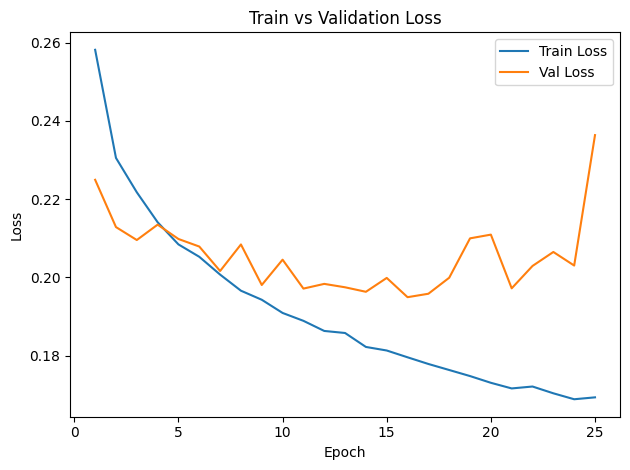

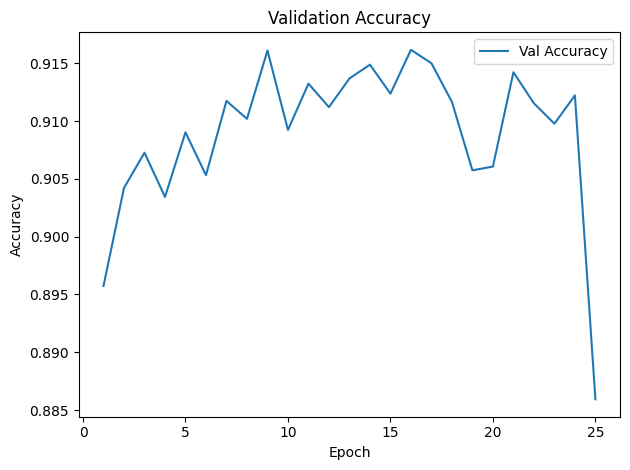

In [16]:
# 13. === Plotting (excluding last 5 extra-watch epochs if present) ===
ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
train_losses = ckpt.get("train_losses", [])
val_losses   = ckpt.get("val_losses", [])
val_accs     = ckpt.get("val_accs", [])

total_recorded = len(train_losses)
cutoff = total_recorded - 5 if total_recorded > 5 else total_recorded
epochs = list(range(1, cutoff + 1))

plt.figure()
plt.plot(epochs, train_losses[:cutoff], label="Train Loss")
plt.plot(epochs, val_losses[:cutoff], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, val_accs[:cutoff], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()



#  --- FINAL TEST ON MAIN TEST SET (NO LoRA) ---


--- Testing best model on hold-out set (NO LoRA) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Test: 100%|███████████████████████████████████████████████████████████████| 313/313 [03:25<00:00,  1.53it/s]

Test Loss: 0.1976 | Acc: 0.9144

              precision    recall  f1-score   support

        Real     0.9306    0.8956    0.9128      2500
        Fake     0.8994    0.9332    0.9160      2500

    accuracy                         0.9144      5000
   macro avg     0.9150    0.9144    0.9144      5000
weighted avg     0.9150    0.9144    0.9144      5000

Confusion matrix:
 [[2239  261]
 [ 167 2333]]


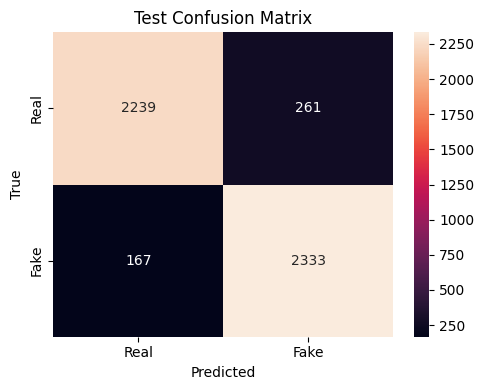

(0.19755242553691324, 0.9143999814987183)

In [17]:
# 14. --- FINAL TEST ON MAIN TEST SET (NO LoRA) ---
print("\n--- Testing best model on hold-out set (NO LoRA) ---")
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto"
)
best_model = BLIP2Classifier(base, processor, BEST_DROPOUT)
best_model.head = best_model.head.to(device)
best_model.head.load_state_dict(torch.load(SAVE_PATH_HEAD, map_location=device))
evaluate(test_loader, best_model, nn.CrossEntropyLoss(), name="Test")



# --- FINAL TEST ON MAIN TEST SET (WITH LoRA) ---


--- Testing best model on hold-out set (WITH LoRA) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Test: 100%|███████████████████████████████████████████████████████████████| 313/313 [03:08<00:00,  1.66it/s]

Test Loss: 0.1976 | Acc: 0.9144

              precision    recall  f1-score   support

        Real     0.9306    0.8956    0.9128      2500
        Fake     0.8994    0.9332    0.9160      2500

    accuracy                         0.9144      5000
   macro avg     0.9150    0.9144    0.9144      5000
weighted avg     0.9150    0.9144    0.9144      5000

Confusion matrix:
 [[2239  261]
 [ 167 2333]]


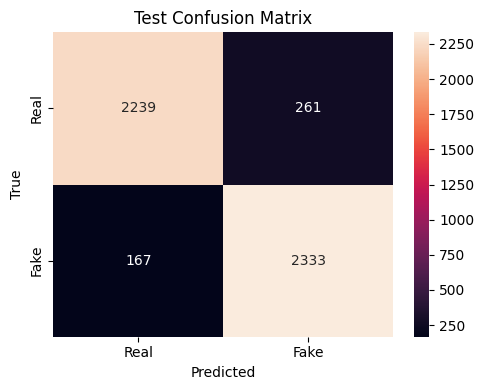

(0.19755242553691324, 0.9143999814987183)

In [18]:
# --- FINAL TEST ON MAIN TEST SET (WITH LoRA) ---
print("\n--- Testing best model on hold-out set (WITH LoRA) ---")
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto"
)
# Manually loading LoRA
lora_path = "C:/K2452367/Dissertation/lora_blip2/model.safetensors"  # or .bin if you saved like that
if lora_path.endswith(".safetensors"):
    lora_state_dict = load_file(lora_path)
else:
    lora_state_dict = torch.load(lora_path, map_location="cpu")
base.load_state_dict(lora_state_dict, strict=False)

lora_model = BLIP2Classifier(base, processor, BEST_DROPOUT)
lora_model.head = lora_model.head.to(device)
lora_model.head.load_state_dict(torch.load(SAVE_PATH_HEAD, map_location=device))
evaluate(test_loader, lora_model, nn.CrossEntropyLoss(), name="Test")



# --- TESTING ON CELEBDF DATASET ---

In [19]:
# 16. --- TESTING ON CELEBDF DATASET (balanced 5k) ---
NEW_TEST_CSV = r"C:\K2452367\Dissertation\Deepfakedetection_masters_2025\celebdf_v2\celeb_df_output_file.csv"
new_test_df_full = pd.read_csv(NEW_TEST_CSV)

# Helper: balanced subsample (binary labels 0/1)
def balanced_subsample(df, n_total=5000, label_col="label", seed=42):
    classes = sorted(df[label_col].unique())
    if len(classes) != 2:
        raise ValueError(f"Expected exactly 2 classes, got {classes}")
    n_per = n_total // 2
    parts = []
    for c in classes:
        df_c = df[df[label_col] == c]
        if len(df_c) < n_per:
            raise ValueError(f"Class {c} has only {len(df_c)} rows; need {n_per}.")
        parts.append(df_c.sample(n=n_per, replace=False, random_state=seed))
    out = pd.concat(parts, axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

# Make a balanced 5k subset
new_test_df = balanced_subsample(new_test_df_full, n_total=5000, label_col="label", seed=42)
print("\nCelebDF balanced label distribution:\n", new_test_df["label"].value_counts().sort_index())

# Loader
new_test_loader = DataLoader(
    DeepfakeBLIPDataset(new_test_df),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=blip_collate,
    pin_memory=True
)



CelebDF balanced label distribution:
 label
0    2500
1    2500
Name: count, dtype: int64


In [20]:
# 17. WITHOUT LoRA
print("\n--- Testing on new data (NO LoRA) ---")
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto"
)
best_model = BLIP2Classifier(base, processor, BEST_DROPOUT)
best_model.head = best_model.head.to(device)
best_model.head.load_state_dict(torch.load(SAVE_PATH_HEAD, map_location=device))
evaluate(new_test_loader, best_model, nn.CrossEntropyLoss(), name="Test", show_confusion=False)



--- Testing on new data (NO LoRA) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Test: 100%|███████████████████████████████████████████████████████████████| 625/625 [05:40<00:00,  1.84it/s]

Test Loss: 1.0687 | Acc: 0.5966

              precision    recall  f1-score   support

        Real     0.6450    0.4296    0.5157      2500
        Fake     0.5724    0.7636    0.6543      2500

    accuracy                         0.5966      5000
   macro avg     0.6087    0.5966    0.5850      5000
weighted avg     0.6087    0.5966    0.5850      5000



(1.068697777068615, 0.5965999960899353)

In [21]:
# 18. WITH LoRA
print("\n--- Testing on new data (WITH LoRA) ---")
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto"
)
lora_path = SAVE_PATH_BASE + "/model.safetensors"
lora_state_dict = load_file(lora_path)
base.load_state_dict(lora_state_dict, strict=False)

lora_model = BLIP2Classifier(base, processor, BEST_DROPOUT)
lora_model.head = lora_model.head.to(device)
lora_model.head.load_state_dict(torch.load(SAVE_PATH_HEAD, map_location=device))
evaluate(new_test_loader, lora_model, nn.CrossEntropyLoss(), name="Test", show_confusion=False)




--- Testing on new data (WITH LoRA) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Test: 100%|███████████████████████████████████████████████████████████████| 625/625 [05:49<00:00,  1.79it/s]

Test Loss: 1.0687 | Acc: 0.5966

              precision    recall  f1-score   support

        Real     0.6450    0.4296    0.5157      2500
        Fake     0.5724    0.7636    0.6543      2500

    accuracy                         0.5966      5000
   macro avg     0.6087    0.5966    0.5850      5000
weighted avg     0.6087    0.5966    0.5850      5000



(1.068697777068615, 0.5965999960899353)

# Testing on wilddeepfake dataset

In [22]:
# 19. --- Testing on WildDeepfake (balanced 5k) ---
WILD_TEST_CSV = r"C:\K2452367\Dissertation\Deepfakedetection_masters_2025\wilddeepfake\wilddeepfake_test.csv"
wild_test_df_full = pd.read_csv(WILD_TEST_CSV)

# Reuse the same helper; define if not already defined above
def balanced_subsample(df, n_total=5000, label_col="label", seed=42):
    classes = sorted(df[label_col].unique())
    if len(classes) != 2:
        raise ValueError(f"Expected exactly 2 classes, got {classes}")
    n_per = n_total // 2
    parts = []
    for c in classes:
        df_c = df[df[label_col] == c]
        if len(df_c) < n_per:
            raise ValueError(f"Class {c} has only {len(df_c)} rows; need {n_per}.")
        parts.append(df_c.sample(n=n_per, replace=False, random_state=seed))
    out = pd.concat(parts, axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

# Make a balanced 5k subset
wild_test_df = balanced_subsample(wild_test_df_full, n_total=5000, label_col="label", seed=42)
print("\nWildDeepfake balanced label distribution:\n", wild_test_df["label"].value_counts().sort_index())

# Loader
wild_test_loader = DataLoader(
    DeepfakeBLIPDataset(wild_test_df),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=blip_collate,
    pin_memory=True
)



WildDeepfake balanced label distribution:
 label
0    2500
1    2500
Name: count, dtype: int64


In [23]:
# 20. Testing on WildDeepfake WITHOUT LoRA
print("\n--- Testing on WildDeepfake (NO LoRA) ---")
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto"
)
model_no_lora = BLIP2Classifier(base, processor, BEST_DROPOUT)
model_no_lora.head = model_no_lora.head.to(device)
model_no_lora.head.load_state_dict(torch.load(SAVE_PATH_HEAD, map_location=device))
evaluate(wild_test_loader, model_no_lora, nn.CrossEntropyLoss(), name="WildDeepfake (No LoRA)", show_confusion=False)




--- Testing on WildDeepfake (NO LoRA) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating WildDeepfake (No LoRA): 100%|█████████████████████████████████████████████| 625/625 [06:02<00:00,  1.73it/s]

WildDeepfake (No LoRA) Loss: 1.0579 | Acc: 0.6870

              precision    recall  f1-score   support

        Real     0.7334    0.5876    0.6525      2500
        Fake     0.6560    0.7864    0.7153      2500

    accuracy                         0.6870      5000
   macro avg     0.6947    0.6870    0.6839      5000
weighted avg     0.6947    0.6870    0.6839      5000



(1.0578940425932408, 0.6869999766349792)

In [24]:
# 21. Testing on WildDeepfake WITH LoRA
print("\n--- Testing on WildDeepfake (WITH LoRA) ---")
base = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    return_dict=True,
)
base.config.output_hidden_states = True

# Load LoRA adapter weights (manual)
lora_path = os.path.join(SAVE_PATH_BASE, "model.safetensors")
lora_state_dict = load_file(lora_path)
missing, unexpected = base.load_state_dict(lora_state_dict, strict=False)
print(f"LoRA load → missing={len(missing)}, unexpected={len(unexpected)}")

# Build wrapper WITHOUT moving the base; move only head
model_with_lora = BLIP2Classifier(base, processor, BEST_DROPOUT)
model_with_lora.head = model_with_lora.head.to(device)
model_with_lora.head.load_state_dict(torch.load(SAVE_PATH_HEAD, map_location=device))

evaluate(
    wild_test_loader,
    model_with_lora,
    nn.CrossEntropyLoss(),
    name="WildDeepfake (With LoRA)",
    show_confusion=False,
)


--- Testing on WildDeepfake (WITH LoRA) ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LoRA load → missing=517, unexpected=1028


Evaluating WildDeepfake (With LoRA): 100%|███████████████████████████████████████████| 625/625 [06:08<00:00,  1.70it/s]

WildDeepfake (With LoRA) Loss: 1.0579 | Acc: 0.6870

              precision    recall  f1-score   support

        Real     0.7334    0.5876    0.6525      2500
        Fake     0.6560    0.7864    0.7153      2500

    accuracy                         0.6870      5000
   macro avg     0.6947    0.6870    0.6839      5000
weighted avg     0.6947    0.6870    0.6839      5000



(1.0578940425932408, 0.6869999766349792)

# Confusion Matrices

In [25]:
# 22.Get predictions & labels for each dataset without printing reports or CMs
_, _, main_preds, main_labels = evaluate(
    test_loader,
    best_model,
    nn.CrossEntropyLoss(),
    name="Main Test",
    return_preds=True,
    show_report=False,
    show_confusion=False,
)
_, _, celeb_preds, celeb_labels = evaluate(
    new_test_loader,
    lora_model,
    nn.CrossEntropyLoss(),
    name="CelebDF",
    return_preds=True,
    show_report=False,
    show_confusion=False,
)
_, _, wild_preds, wild_labels = evaluate(
    wild_test_loader,
    model_with_lora,
    nn.CrossEntropyLoss(),
    name="WildDeepfake",
    return_preds=True,
    show_report=False,
    show_confusion=False,
)



Evaluating Main Test: 100%|██████████████████████████████████████████████████████████| 313/313 [03:34<00:00,  1.46it/s]


Main Test Loss: 0.1976 | Acc: 0.9144



Evaluating CelebDF: 100%|████████████████████████████████████████████████████████████| 625/625 [05:45<00:00,  1.81it/s]


CelebDF Loss: 1.0687 | Acc: 0.5966



Evaluating WildDeepfake: 100%|███████████████████████████████████████████████████████| 625/625 [05:25<00:00,  1.92it/s]

WildDeepfake Loss: 1.0579 | Acc: 0.6870



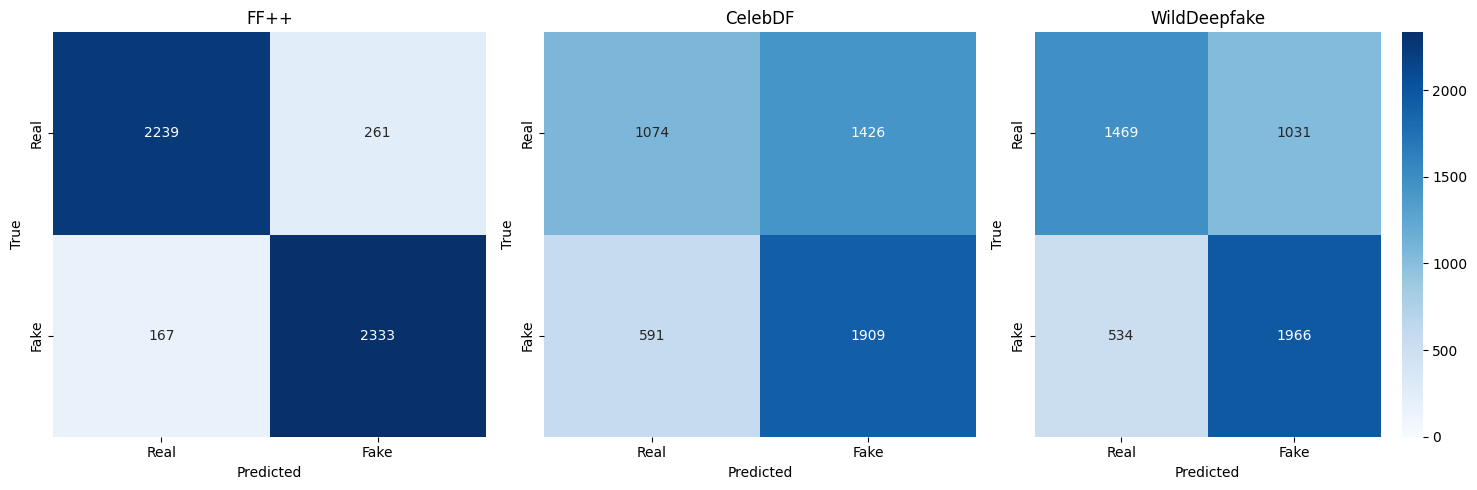

In [26]:
# 23. Compute confusion matrices
cm_main = confusion_matrix(main_labels, main_preds)
cm_celeb = confusion_matrix(celeb_labels, celeb_preds)
cm_wild = confusion_matrix(wild_labels, wild_preds)

# Plot all three with same color scale
def plot_three_cms(cms, titles, class_names=["Real", "Fake"], figsize=(15,5), cmap="Blues"):
    max_val = max(cm.max() for cm in cms)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for ax, cm, title in zip(axes, cms, titles):
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            vmin=0,
            vmax=max_val,
            cmap=cmap,
            cbar=(ax is axes[-1]),
            ax=ax,
        )
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_three_cms(
    [cm_main, cm_celeb, cm_wild],
    titles=["FF++", "CelebDF", "WildDeepfake"],
    class_names=["Real", "Fake"],
    cmap="Blues"
)



Scoring for ROC: 100%|███████████████████████████████████████████████████████████████| 625/625 [05:32<00:00,  1.88it/s]


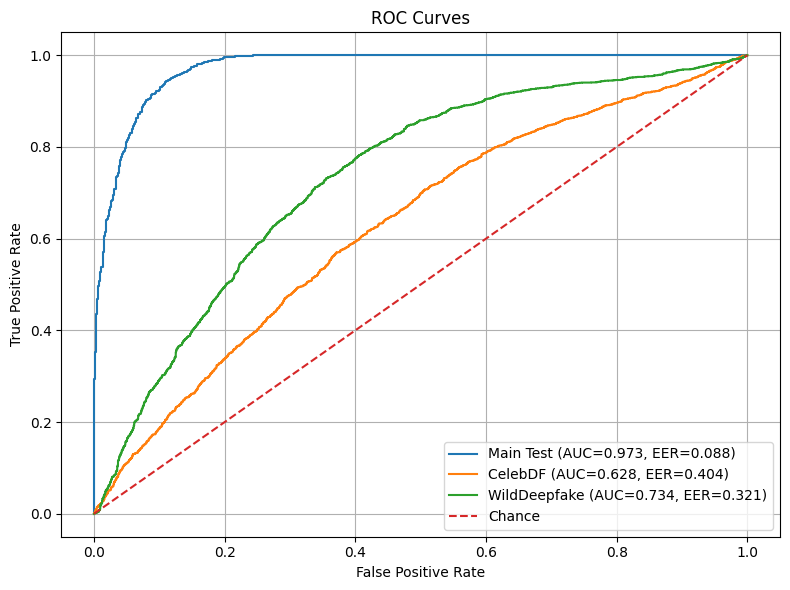

In [27]:
# 24. Plotting ROC curves with AUC & EER
def compute_roc_metrics(loader, model):
    model.eval()
    all_labels = []
    all_scores = []  # score for positive class (assumed label=1)
    with torch.no_grad():
        for imgs, txts, lbls in tqdm(loader, desc="Scoring for ROC"):
            lbls = lbls.to(device)
            logits = model(imgs, txts)  # [B, 2]
            probs = F.softmax(logits, dim=1)
            pos_scores = probs[:, 1]  # score for class 1
            all_scores.extend(pos_scores.cpu().tolist())
            all_labels.extend(lbls.cpu().tolist())

    y_true = np.array(all_labels)
    y_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Compute EER
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2

    # Optional interpolation
    diff = fpr - fnr
    try:
        f = interpolate.interp1d(diff, thresholds, kind="linear")
        thr_at_eer = f(0.0)
        fpr_interp = interpolate.interp1d(thresholds[::-1], fpr[::-1], bounds_error=False, fill_value="extrapolate")
        tpr_interp = interpolate.interp1d(thresholds[::-1], tpr[::-1], bounds_error=False, fill_value="extrapolate")
        fpr_eer = fpr_interp(thr_at_eer)
        tpr_eer = tpr_interp(thr_at_eer)
        fnr_eer = 1 - tpr_eer
        eer = float((fpr_eer + fnr_eer) / 2)
    except Exception:
        pass

    return fpr, tpr, roc_auc, eer

# Compute for each dataset/model (swap in the exact model variants used)
fpr_main, tpr_main, auc_main, eer_main = compute_roc_metrics(test_loader, best_model)
fpr_celeb, tpr_celeb, auc_celeb, eer_celeb = compute_roc_metrics(new_test_loader, lora_model)
fpr_wild, tpr_wild, auc_wild, eer_wild = compute_roc_metrics(wild_test_loader, model_with_lora)

# Plot combined ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_main, tpr_main, label=f"Main Test (AUC={auc_main:.3f}, EER={eer_main:.3f})")
plt.plot(fpr_celeb, tpr_celeb, label=f"CelebDF (AUC={auc_celeb:.3f}, EER={eer_celeb:.3f})")
plt.plot(fpr_wild, tpr_wild, label=f"WildDeepfake (AUC={auc_wild:.3f}, EER={eer_wild:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



# Getting classification reports

In [28]:
# 25. Get predictions and labels for each dataset without printing confusion matrices
_, _, main_preds, main_labels = evaluate(
    test_loader,
    best_model,
    nn.CrossEntropyLoss(),
    name="Main Test",
    return_preds=True,
    show_report=False,
    show_confusion=False,
)
_, _, celeb_preds, celeb_labels = evaluate(
    new_test_loader,
    lora_model,
    nn.CrossEntropyLoss(),
    name="CelebDF",
    return_preds=True,
    show_report=False,
    show_confusion=False,
)
_, _, wild_preds, wild_labels = evaluate(
    wild_test_loader,
    model_with_lora,
    nn.CrossEntropyLoss(),
    name="WildDeepfake",
    return_preds=True,
    show_report=False,
    show_confusion=False,
)

# Print classification reports
print("\n=== Classification Report: Main Test Set ===")
print(classification_report(main_labels, main_preds, target_names=["Real", "Fake"], digits=4))

print("\n=== Classification Report: CelebDF ===")
print(classification_report(celeb_labels, celeb_preds, target_names=["Real", "Fake"], digits=4))

print("\n=== Classification Report: WildDeepfake ===")
print(classification_report(wild_labels, wild_preds, target_names=["Real", "Fake"], digits=4))



Evaluating Main Test: 100%|██████████████████████████████████████████████████████████| 313/313 [03:27<00:00,  1.51it/s]


Main Test Loss: 0.1976 | Acc: 0.9144



Evaluating CelebDF: 100%|████████████████████████████████████████████████████████████| 625/625 [05:28<00:00,  1.90it/s]


CelebDF Loss: 1.0687 | Acc: 0.5966



Evaluating WildDeepfake: 100%|███████████████████████████████████████████████████████| 625/625 [05:50<00:00,  1.78it/s]

WildDeepfake Loss: 1.0579 | Acc: 0.6870


=== Classification Report: Main Test Set ===
              precision    recall  f1-score   support

        Real     0.9306    0.8956    0.9128      2500
        Fake     0.8994    0.9332    0.9160      2500

    accuracy                         0.9144      5000
   macro avg     0.9150    0.9144    0.9144      5000
weighted avg     0.9150    0.9144    0.9144      5000


=== Classification Report: CelebDF ===
              precision    recall  f1-score   support

        Real     0.6450    0.4296    0.5157      2500
        Fake     0.5724    0.7636    0.6543      2500

    accuracy                         0.5966      5000
   macro avg     0.6087    0.5966    0.5850      5000
weighted avg     0.6087    0.5966    0.5850      5000


=== Classification Report: WildDeepfake ===
              precision    recall  f1-score   support

        Real     0.7334    0.5876    0.6525      2500
        Fake     0.6560    0.7864    0.7153      2500

    accura

In [60]:
# === Better CAMs for BLIP-2: input_grad, smoothgrad, vit_rollout ===
class GradCAM_BLIP2:
    """
    Modes:
      - 'input_grad'  : your current saliency over pixel_values (fast)
      - 'smoothgrad'  : averages N noisy input_grad maps (cleaner)
      - 'vit_rollout' : attention rollout from the vision transformer (no grads)
    During grad-based modes we temporarily co-locate Q-Former + head on the vision GPU
    to keep the graph on one device and get non-None pixel grads.
    """
    def __init__(self, model, mode: str = "input_grad",
                 smooth_samples: int = 8, smooth_sigma: float = 0.08,
                 rollout_layers: int | None = None,  # None = all layers
                 blur_sigma: float = 0.0,            # e.g., 1.0 for light blur
                 percentile: float = 99.0,           # clamp high outliers
                 gamma: float = 1.0):                # non-linear boost (>1 darkens, <1 boosts)
        assert mode in ("input_grad", "smoothgrad", "vit_rollout")
        self.model = model.eval()
        self.mode = mode
        self.smooth_samples = smooth_samples
        self.smooth_sigma   = smooth_sigma
        self.rollout_layers = rollout_layers
        self.blur_sigma     = blur_sigma
        self.percentile     = percentile
        self.gamma          = gamma

    # ---- utils ----
    def _to_vision_leaf(self, pixel_values, device):
        leaf = (pixel_values.to(device).clone().detach().requires_grad_(True))
        return leaf

    def _overlay(self, pil_or_tensor, saliency_np):
        # percentile clip -> normalize -> gamma -> optional blur -> overlay
        import numpy as np, matplotlib.pyplot as plt
        from PIL import Image
        if self.percentile is not None:
            hi = np.percentile(saliency_np, self.percentile)
            saliency_np = np.clip(saliency_np, 0, max(1e-12, hi))
        sal = saliency_np - saliency_np.min()
        sal = sal / (sal.max() + 1e-12)
        if self.gamma and self.gamma != 1.0:
            sal = sal ** self.gamma
        if self.blur_sigma and self.blur_sigma > 0:
            import cv2
            k = max(3, int(6*self.blur_sigma)|1)
            sal = cv2.GaussianBlur(sal, (k, k), self.blur_sigma)

        if isinstance(pil_or_tensor, torch.Tensor):
            from torchvision.transforms.functional import to_pil_image
            orig = to_pil_image(pil_or_tensor.cpu())
        else:
            orig = pil_or_tensor

        heat = (plt.cm.jet(sal)[..., :3] * 255).astype(np.uint8)
        heat_img = Image.fromarray(heat).resize(orig.size, resample=Image.BILINEAR)
        return Image.blend(orig.convert("RGBA"), heat_img.convert("RGBA"), alpha=0.40)

    def _force_eager_for_attn(self):
        # Force eager so attentions can be returned even if SDPA is default
        cfg = getattr(self.model.base, "config", None)
        if cfg is None: return
        vcfg = getattr(cfg, "vision_config", None)
        if vcfg is not None:
            vcfg.output_attentions = True
            if hasattr(vcfg, "attn_implementation"):
                vcfg.attn_implementation = "eager"
            if hasattr(vcfg, "_attn_implementation"):
                vcfg._attn_implementation = "eager"
        # Helpful global switches (safe if unsupported)
        try:
            torch.backends.cuda.enable_flash_sdp(False)
            torch.backends.cuda.enable_mem_efficient_sdp(False)
            torch.backends.cuda.enable_math_sdp(True)
        except Exception:
            pass

    # ---- main entry ----
    def generate_cam(self, image, text=None, target_class: int | None = None):
        from torchvision.transforms.functional import to_pil_image
        txt = text if text is not None else ""

        # Build processor batch on CPU
        if isinstance(image, torch.Tensor):
            proc = self.model.proc(images=image.unsqueeze(0), text=[txt], return_tensors="pt", padding=True)
        else:
            proc = self.model.proc(images=[image], text=[txt], return_tensors="pt", padding=True)

        # Devices
        vision_device = next(self.model.base.vision_model.parameters()).device
        qformer       = self.model.base.qformer
        head          = self.model.head
        qf_dev0       = next(qformer.parameters()).device
        head_dev0     = next(head.parameters()).device
        lm_device     = next(self.model.base.language_model.parameters()).device

        # Build unified inputs dict, keeping a leaf pixel tensor for grads when needed
        if self.mode in ("input_grad", "smoothgrad"):
            pixel_leaf = self._to_vision_leaf(proc["pixel_values"], vision_device)
        else:
            pixel_leaf = proc["pixel_values"].to(vision_device)

        inputs = {"pixel_values": pixel_leaf}
        for k in ("input_ids", "attention_mask", "position_ids"):
            if k in proc:
                inputs[k] = proc[k].to(lm_device)

        # Temporarily move qformer + head to vision device for grad modes
        need_move_qf   = (qf_dev0   != vision_device)
        need_move_head = (head_dev0 != vision_device)

        try:
            if self.mode in ("input_grad", "smoothgrad"):
                if need_move_qf:   qformer.to(vision_device)
                if need_move_head: head.to(vision_device)

                # forward once to get logits/probs
                outs = self.model.base(**inputs, return_dict=True, output_hidden_states=True)
                q_last = outs.qformer_outputs.last_hidden_state
                pooled = q_last.mean(dim=1).float()
                logits = head(pooled)
                probs  = F.softmax(logits, dim=1)
                pred   = int(probs.argmax(dim=1))
                target = pred if target_class is None else int(target_class)

                if self.mode == "input_grad":
                    score = probs[0, target]
                    self.model.zero_grad(set_to_none=True)
                    score.backward()
                    if inputs["pixel_values"].grad is None:
                        raise RuntimeError("pixel_values.grad is None (device mismatch?).")
                    sal = inputs["pixel_values"].grad.detach().abs().mean(dim=1)[0].cpu().numpy()

                else:  # SmoothGrad
                    base_pix = inputs["pixel_values"]
                    acc = None
                    for _ in range(self.smooth_samples):
                        noise = torch.randn_like(base_pix) * self.smooth_sigma
                        noisy = (base_pix + noise).clone().detach().requires_grad_(True)
                        in2 = dict(inputs); in2["pixel_values"] = noisy
                        outs2 = self.model.base(**in2, return_dict=True, output_hidden_states=True)
                        pooled2 = outs2.qformer_outputs.last_hidden_state.mean(dim=1).float()
                        logits2 = head(pooled2); probs2 = F.softmax(logits2, dim=1)
                        score2 = probs2[0, target]
                        self.model.zero_grad(set_to_none=True)
                        score2.backward()
                        g = noisy.grad.detach().abs().mean(dim=1)  # [B,H,W]
                        acc = g if acc is None else (acc + g)
                    sal = (acc / float(self.smooth_samples))[0].cpu().numpy()

                overlay = self._overlay(image, sal)
                conf = float(probs[0, pred].detach().cpu())
                return overlay, pred, conf

            else:  # 'vit_rollout' (no grads, cleaner large blobs)
                self._force_eager_for_attn()
                outs = self.model.base(
                    **inputs,
                    return_dict=True,
                    output_attentions=True,
                    output_hidden_states=False
                )
                # vision attentions: list[L] of [B, heads, tokens, tokens]
                vouts = getattr(outs, "vision_outputs", None)
                if vouts is None or vouts.attentions is None:
                    raise RuntimeError("Vision attentions not returned. Could not do rollout.")
                attns = vouts.attentions  # tuple of layers
                L = len(attns) if self.rollout_layers is None else int(self.rollout_layers)
                attns = attns[-L:] if self.rollout_layers else attns

                # rollout (Chefer et al.): add identity & multiply across layers
                rollout = None
                for A in attns:
                    A = A.mean(dim=1)  # average heads → [B,T,T]
                    T = A.size(-1)
                    I = torch.eye(T, device=A.device).unsqueeze(0)
                    A = (A + I) / (A + I).sum(dim=-1, keepdim=True)
                    rollout = A if rollout is None else torch.bmm(A, rollout)

                # take CLS attention to patches
                cls_attn = rollout[:, 0, 1:]  # [B, T_patches]
                # infer grid from vision patching
                num_patches = cls_attn.size(-1)
                side = int(num_patches ** 0.5)
                cls_map = cls_attn[0].reshape(side, side).detach().cpu().numpy()
                # upscale to image size
                import cv2
                sal = cv2.resize(cls_map, (proc["pixel_values"].shape[-1], proc["pixel_values"].shape[-2]),
                                 interpolation=cv2.INTER_CUBIC)
                overlay = self._overlay(image, sal)
                # we can still report the classifier’s pred prob (quick forward)
                q_last = outs.qformer_outputs.last_hidden_state
                pooled = q_last.mean(dim=1).float().to(head.device)
                logits = head.to(pooled.device)(pooled)
                probs  = F.softmax(logits, dim=1)
                pred   = int(probs.argmax(dim=1))
                conf   = float(probs[0, pred].detach().cpu())
                return overlay, pred, conf

        finally:
            # restore placement
            if need_move_qf:   qformer.to(qf_dev0)
            if need_move_head: head.to(head_dev0)


In [61]:
def display_gradcams(loader, model, dataset_name, num_examples=8, mode="input_grad"):
    model.eval()
    cam = GradCAM_BLIP2(model, mode=mode,           # try "smoothgrad" or "vit_rollout"
                        smooth_samples=12, smooth_sigma=0.08,
                        blur_sigma=1.0, percentile=99.0, gamma=0.8)

    import math
    cols = min(4, max(1, num_examples))
    rows = math.ceil(num_examples / cols)
    plt.figure(figsize=(4*cols, 3*rows))

    count = 0
    for imgs, txts, lbls in loader:
        for img, txt, lbl in zip(imgs, txts, lbls):
            if count >= num_examples: break
            try:
                overlay, pred, conf = cam.generate_cam(img, text=txt)
            except Exception as e:
                print("GradCAM failure:", e); continue
            ax = plt.subplot(rows, cols, count+1)
            ax.imshow(overlay); ax.axis("off")
            ax.set_title(f"GT:{'Real' if lbl==0 else 'Fake'} | P:{'Real' if pred==0 else 'Fake'} | conf={conf:.2f}",
                         fontsize=9)
            count += 1
        if count >= num_examples: break
    plt.suptitle(f"Grad-CAM overlays ({dataset_name}) • mode={mode}", fontsize=12)
    plt.tight_layout(); plt.show()


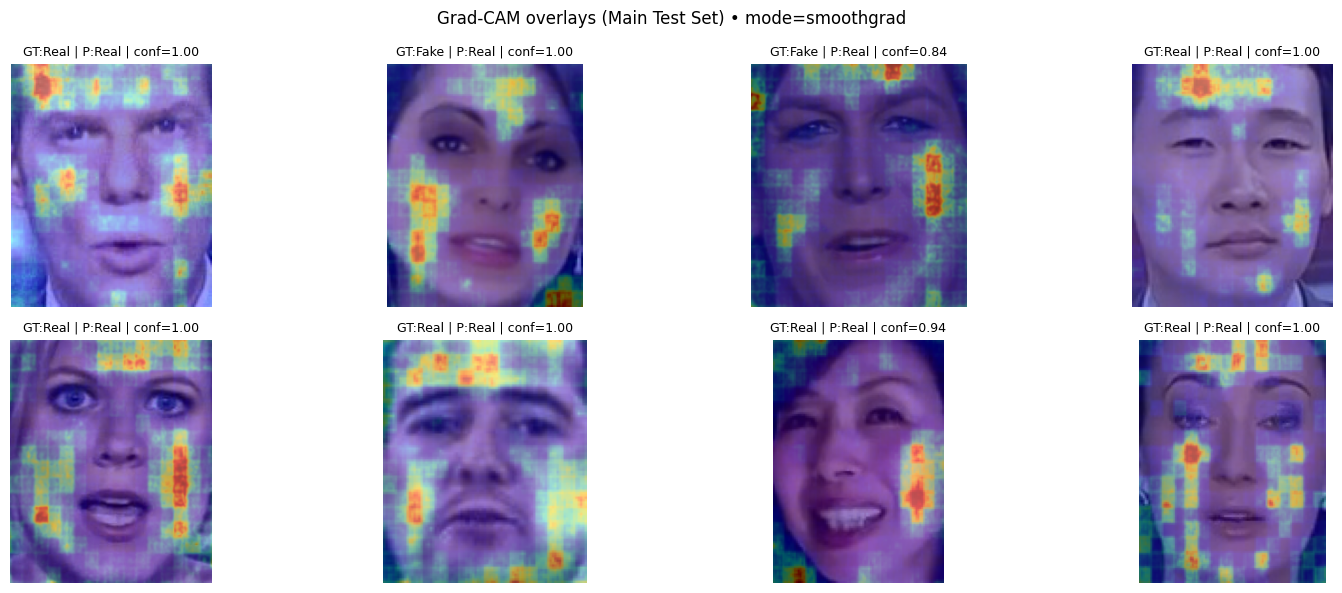

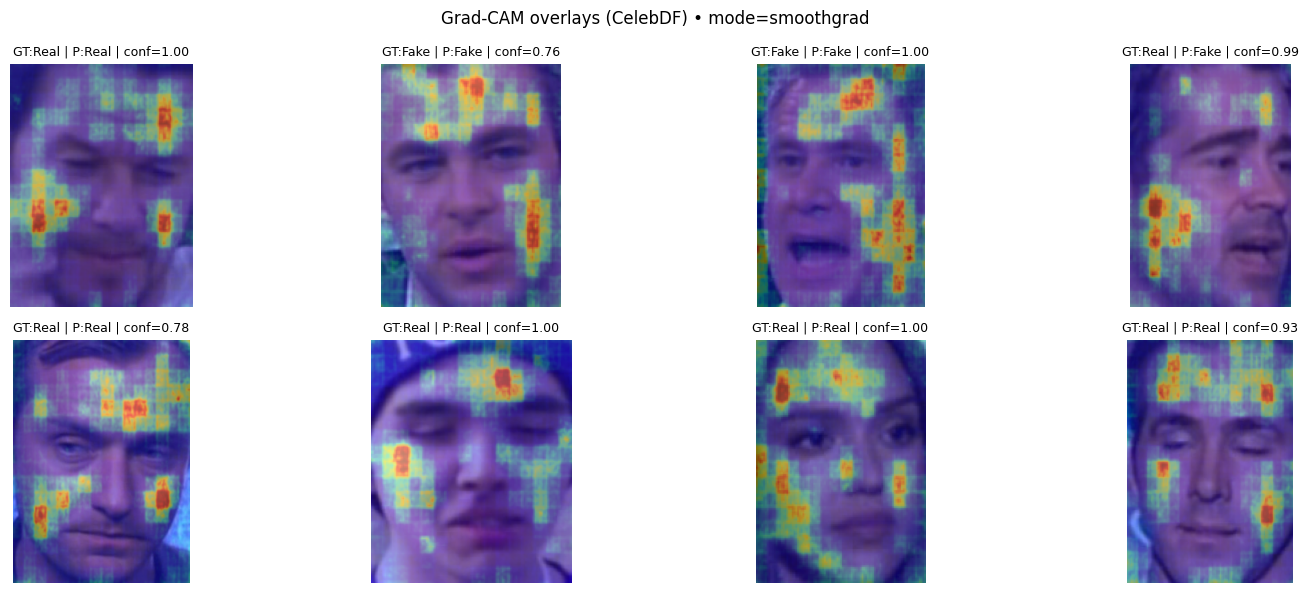

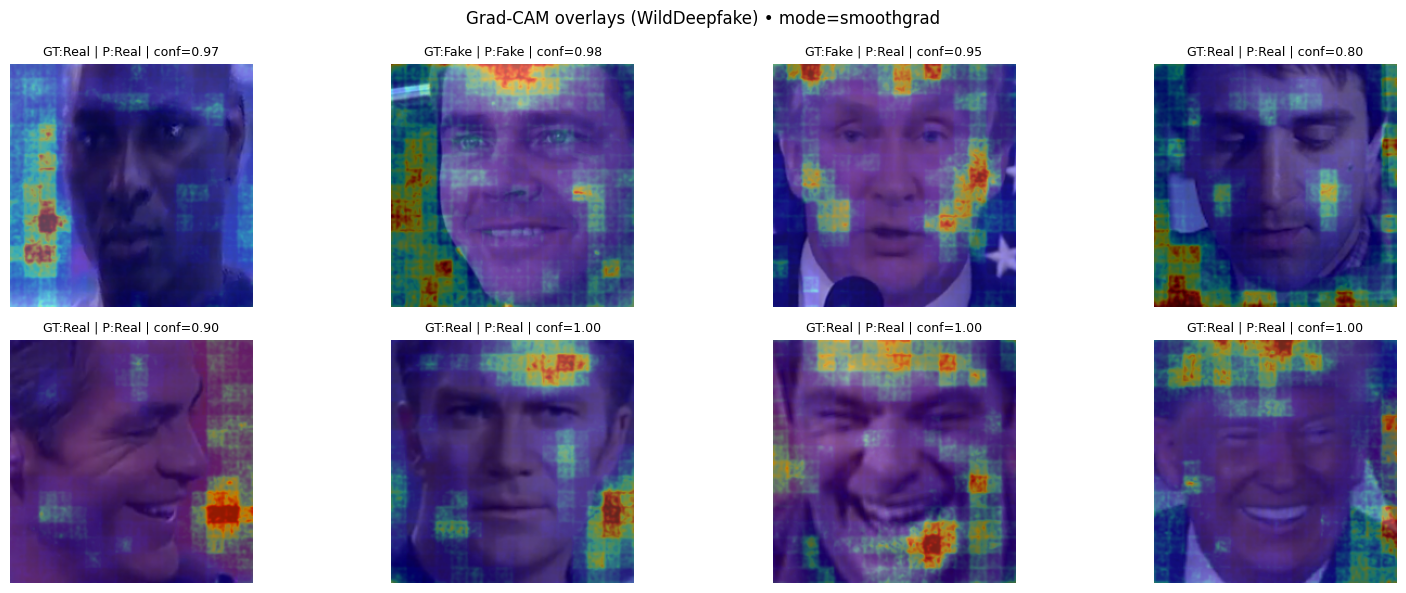

In [63]:
# Cleaner gradients
display_gradcams(test_loader,        best_model,      "Main Test Set",  num_examples=8, mode="smoothgrad")
display_gradcams(new_test_loader,    lora_model,      "CelebDF",        num_examples=8, mode="smoothgrad")
display_gradcams(wild_test_loader,   model_with_lora, "WildDeepfake",   num_examples=8, mode="smoothgrad")
